### [EXP_08] 네이버 영화 리뷰 감성분석 도전하기

0. 라이브러리 준비

In [46]:
import pandas
import konlpy
import gensim
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import pandas as pd
import tensorflow as tf
import os, re
import random
import scipy.stats
import matplotlib.pyplot as plt
from tensorflow.keras.initializers import Constant
from gensim.models.keyedvectors import Word2VecKeyedVectors

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

# 랜덤시드를 설정함.
random_seed = 204
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)


1.3.3
0.5.2
4.1.2


1. 데이터 준비와 확인

In [47]:

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB
None


2. 데이터로더 구성

In [100]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
    
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label']), dtype=np.int64), X_test, np.array(list(test_data['label']), dtype=np.int64), word_to_index
    

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data, num_words=50000)

index_to_word = {index:word for word, index in word_to_index.items()}

print('done:', len(X_train), len(y_train), len(X_test), len(y_test), len(word_to_index))

done: 146182 146182 49157 49157 49997


In [93]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트로 변환해 주는 함수를 만들어 봅시다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in tokenizer.morphs(sentence)]


# 여러 개의 문장 리스트를 한꺼번에 숫자 텐서로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]


# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '' for index in encoded_sentence[:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]


In [101]:
enc = get_encoded_sentences(["거기 누구 없어", "하늘 아래 조용히"], word_to_index)
print(enc)

[[846, 609, 17, 35], [2064, 1939, 3908]]


In [102]:
dec = get_decoded_sentences(enc, index_to_word)
dec

['거기 누구 없 어', '하늘 아래 조용히']

3. 모델 구성을 위한 데이터 분석 및 가공

In [103]:
# 데이터셋 내 문장 길이 분포.

xtrain_sentence_lens = [ len(sentence) for sentence in X_train]
xtest_sentence_lens = [ len(sentence) for sentence in X_test]
xtrain_sentence_lens.extend(xtest_sentence_lens)

sorted_lens = sorted(xtrain_sentence_lens)
sorted_lens_ar = np.array(sorted_lens)

length_mean = np.mean(xtrain_sentence_lens)
length_std = np.std(xtrain_sentence_lens)

norm_dist = scipy.stats.norm(loc = length_mean, scale = length_std)

# 전체 문장의 97%를 커버하는 길이를 선정.
max_token_len = int(norm_dist.ppf(0.97))

# max_tokens = np.mean(sorted_lens_ar) + 2 * np.std(sorted_lens_ar)

max_token_len

40

In [104]:
#적절한 최대 문장 길이 지정 max_token_len으로 설정.

X_train_tmp = []
y_train_tmp = []
X_test_tmp = []
y_test_tmp = []

# 최대 길이를 넘으면, 문장을 잘라낼수도 있으나, 학습시 올바르지 않을 수 있으므로 문장을 제거함.
for sentence, y in zip(X_train, y_train):
    if len(sentence) <= max_token_len:
        X_train_tmp.append(sentence)
        y_train_tmp.append(y)
    
X_train = X_train_tmp
y_train = np.array(y_train_tmp, dtype=np.int64)

for sentence, y in zip(X_test, y_test):
    if len(sentence) <= max_token_len:
        X_test_tmp.append(sentence)
        y_test_tmp.append(y)
  
X_test = X_test_tmp
y_test = np.array(y_test_tmp, dtype=np.int64)

print(len(X_test), len(y_test))


45772 45772


In [106]:
# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

vocab_size = len(word_to_index)
word_vector_dim = 4    # 위 그림과 같이 4차원의 워드 벡터를 가정합니다. 

# 숫자로 변환된 텍스트 데이터 [[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]] 에 Embedding 레이어를 적용합니다. 
train_inputs = np.array(X_train, dtype='object')
test_inputs = np.array(X_test, dtype='object')

x_train = tf.keras.preprocessing.sequence.pad_sequences(train_inputs,
                                                       value=word_to_index[''],
                                                       padding='post',
                                                       maxlen=max_token_len)
x_test = tf.keras.preprocessing.sequence.pad_sequences(test_inputs,
                                                       value=word_to_index[''],
                                                       padding='post',
                                                       maxlen=max_token_len)
print('done')

done


4. 모델 구성 및 validation set 구성.  
5. 모델 훈련 개시  

In [107]:
# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000] #np.array(y_train[:10000], dtype=np.int64)

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

BUFFER_SIZE = len(partial_x_train)
BATCH_SIZE = 256
steps_per_epoch = len(partial_x_train) // BATCH_SIZE

dataset = tf.data.Dataset.from_tensor_slices((partial_x_train, partial_y_train))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

TEST_BUFFER_SIZE = len(x_test)
test_steps_per_epoch = len(x_test) // BATCH_SIZE

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.shuffle(TEST_BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

print('done')


done


In [108]:
# model 1

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 4)           199988    
_________________________________________________________________
lstm_10 (LSTM)               (None, 8)                 416       
_________________________________________________________________
dense_28 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 9         
Total params: 200,485
Trainable params: 200,485
Non-trainable params: 0
_________________________________________________________________


In [109]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history1 = model.fit(dataset,
                    epochs=epochs,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_val, y_val), verbose=1)


Epoch 1/20
492/492 [==============================] - 4s 6ms/step - loss: 0.6458 - accuracy: 0.5881 - val_loss: 0.4245 - val_accuracy: 0.8232
Epoch 2/20
492/492 [==============================] - 3s 5ms/step - loss: 0.3560 - accuracy: 0.8477 - val_loss: 0.3511 - val_accuracy: 0.8464
Epoch 3/20
492/492 [==============================] - 3s 5ms/step - loss: 0.2990 - accuracy: 0.8772 - val_loss: 0.3435 - val_accuracy: 0.8502
Epoch 4/20
492/492 [==============================] - 3s 5ms/step - loss: 0.2708 - accuracy: 0.8912 - val_loss: 0.3586 - val_accuracy: 0.8457
Epoch 5/20
492/492 [==============================] - 3s 5ms/step - loss: 0.2519 - accuracy: 0.9005 - val_loss: 0.3714 - val_accuracy: 0.8406
Epoch 6/20
492/492 [==============================] - 3s 5ms/step - loss: 0.2362 - accuracy: 0.9087 - val_loss: 0.3976 - val_accuracy: 0.8423
Epoch 7/20
492/492 [==============================] - 3s 5ms/step - loss: 0.2239 - accuracy: 0.9129 - val_loss: 0.4043 - val_accuracy: 0.8345
Epoch 

In [110]:
results = model.evaluate(test_dataset, verbose=2)

178/178 - 1s - loss: 0.6074 - accuracy: 0.8172


In [111]:
# model 2

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, padding='valid', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
# model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 4)           199988    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          464       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 9         
Total params: 200,597
Trainable params: 200,597
Non-trainable params: 0
_______________________________________________

In [112]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history2 = model.fit(dataset,
                    epochs=epochs,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_val, y_val), verbose=1)


Epoch 1/20
492/492 [==============================] - 3s 4ms/step - loss: 0.5610 - accuracy: 0.7292 - val_loss: 0.4532 - val_accuracy: 0.8306
Epoch 2/20
492/492 [==============================] - 2s 4ms/step - loss: 0.4086 - accuracy: 0.8560 - val_loss: 0.3996 - val_accuracy: 0.8460
Epoch 3/20
492/492 [==============================] - 2s 4ms/step - loss: 0.3421 - accuracy: 0.8821 - val_loss: 0.3816 - val_accuracy: 0.8470
Epoch 4/20
492/492 [==============================] - 2s 4ms/step - loss: 0.2966 - accuracy: 0.9001 - val_loss: 0.3807 - val_accuracy: 0.8420
Epoch 5/20
492/492 [==============================] - 2s 4ms/step - loss: 0.2634 - accuracy: 0.9124 - val_loss: 0.3892 - val_accuracy: 0.8449
Epoch 6/20
492/492 [==============================] - 2s 4ms/step - loss: 0.2389 - accuracy: 0.9210 - val_loss: 0.4014 - val_accuracy: 0.8438
Epoch 7/20
492/492 [==============================] - 2s 4ms/step - loss: 0.2195 - accuracy: 0.9280 - val_loss: 0.4149 - val_accuracy: 0.8446
Epoch 

In [113]:
results = model.evaluate(test_dataset, verbose=2)

178/178 - 0s - loss: 0.6494 - accuracy: 0.8230


In [114]:
# model 3

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 4)           199988    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 4)                 0         
_________________________________________________________________
dense_32 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 9         
Total params: 200,037
Trainable params: 200,037
Non-trainable params: 0
_________________________________________________________________


In [115]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history3 = model.fit(dataset,
                    epochs=epochs,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_val, y_val), verbose=1)


Epoch 1/20
492/492 [==============================] - 2s 3ms/step - loss: 0.5689 - accuracy: 0.7319 - val_loss: 0.4250 - val_accuracy: 0.8084
Epoch 2/20
492/492 [==============================] - 2s 3ms/step - loss: 0.3861 - accuracy: 0.8337 - val_loss: 0.3784 - val_accuracy: 0.8247
Epoch 3/20
492/492 [==============================] - 2s 3ms/step - loss: 0.3370 - accuracy: 0.8577 - val_loss: 0.3688 - val_accuracy: 0.8350
Epoch 4/20
492/492 [==============================] - 2s 3ms/step - loss: 0.3070 - accuracy: 0.8720 - val_loss: 0.3703 - val_accuracy: 0.8334
Epoch 5/20
492/492 [==============================] - 2s 3ms/step - loss: 0.2853 - accuracy: 0.8821 - val_loss: 0.3767 - val_accuracy: 0.8331
Epoch 6/20
492/492 [==============================] - 2s 3ms/step - loss: 0.2691 - accuracy: 0.8894 - val_loss: 0.3848 - val_accuracy: 0.8341
Epoch 7/20
492/492 [==============================] - 2s 3ms/step - loss: 0.2563 - accuracy: 0.8961 - val_loss: 0.3939 - val_accuracy: 0.8296
Epoch 

In [116]:
results = model.evaluate(test_dataset, verbose=2)

178/178 - 0s - loss: 0.4957 - accuracy: 0.8179


6. Loss, Accuracy 그래프 시각화

In [117]:
# Loss, Accuracy 그래프 시각화

def draw_loss_accuracy(history):
    history_dict = history1.history
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    # "bo"는 "파란색 점"입니다
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b는 "파란 실선"입니다
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # "ro"는 "빨간색 점"입니다
    plt.plot(epochs, acc, 'ro', label='Training accuracy')
    # r는 "빨간 실선"입니다
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


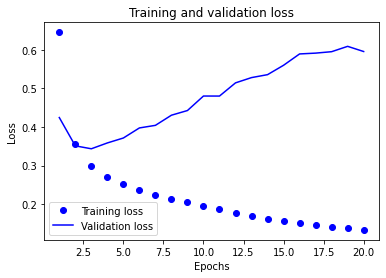

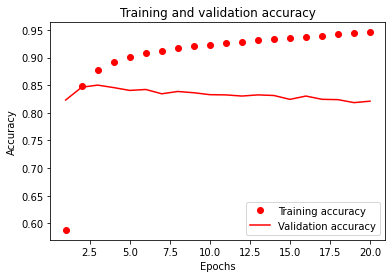

In [118]:
# 안정적인 model1번에 대하여 Loss, Accuracy 그래프 시각화

draw_loss_accuracy(history1)

7. 학습된 Embedding레이어 분석

In [120]:
# 임의의 데이터로 학습 결과 확인.
# 긍정/부정 리뷰를 올바로 분석함.

test_sentences = get_encoded_sentences(["연기 너무 못해요...", "훌륭한 배우의 연기라니 기대되요!."], word_to_index)

# print("encoded:", test_sentences)
# print("decoded:", get_decoded_sentences(test_sentences, index_to_word))

test_sentences = tf.keras.preprocessing.sequence.pad_sequences(test_sentences,
                                                       value=word_to_index[''],
                                                       padding='post',
                                                       maxlen=max_token_len)
result = model.predict(test_sentences)
print("accuracy: \n", result)

accuracy: 
 [[0.16027658]
 [0.98932904]]


In [121]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/myword2vec2.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

(49997, 4)


In [122]:
print(weights[10])

[-0.31884047 -0.22165883 -0.34695098 -0.34331527]


8. 한국어 Word2Vec임베딩 활용하여 성능 개선

In [123]:
# 외부 학습된 데이터 사용..

word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)

word2vec = word_vectors

new_vocab_size = vocab_size
# new_vocab_size = word_vectors.corpus_count
word_vector_dim = 100  # 워드 벡터의 차원수

embedding_matrix = np.random.rand(new_vocab_size, word_vector_dim)

# # embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4, vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

print('done')

done


In [127]:
# 학습된 파라메타를 이용하여 모델 구성.

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=max_token_len, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(32))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 40, 100)           4999700   
_________________________________________________________________
lstm_12 (LSTM)               (None, 32)                17024     
_________________________________________________________________
dense_37 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 9         
Total params: 5,017,397
Trainable params: 5,017,397
Non-trainable params: 0
___________________________________________

In [128]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history4 = model.fit(dataset,
                    epochs=epochs,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_val, y_val), verbose=1)


Epoch 1/20
492/492 [==============================] - 6s 8ms/step - loss: 0.6832 - accuracy: 0.5260 - val_loss: 0.5473 - val_accuracy: 0.7274
Epoch 2/20
492/492 [==============================] - 4s 7ms/step - loss: 0.4475 - accuracy: 0.7966 - val_loss: 0.3823 - val_accuracy: 0.8342
Epoch 3/20
492/492 [==============================] - 4s 7ms/step - loss: 0.3416 - accuracy: 0.8559 - val_loss: 0.3508 - val_accuracy: 0.8424
Epoch 4/20
492/492 [==============================] - 4s 7ms/step - loss: 0.2942 - accuracy: 0.8802 - val_loss: 0.3423 - val_accuracy: 0.8529
Epoch 5/20
492/492 [==============================] - 4s 7ms/step - loss: 0.2594 - accuracy: 0.8969 - val_loss: 0.3492 - val_accuracy: 0.8489
Epoch 6/20
492/492 [==============================] - 4s 7ms/step - loss: 0.2316 - accuracy: 0.9103 - val_loss: 0.3523 - val_accuracy: 0.8506
Epoch 7/20
492/492 [==============================] - 4s 7ms/step - loss: 0.2101 - accuracy: 0.9193 - val_loss: 0.3838 - val_accuracy: 0.8498
Epoch 

In [129]:
results = model.evaluate(test_dataset, verbose=2)

178/178 - 1s - loss: 0.5515 - accuracy: 0.8365


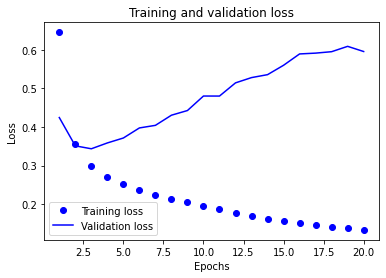

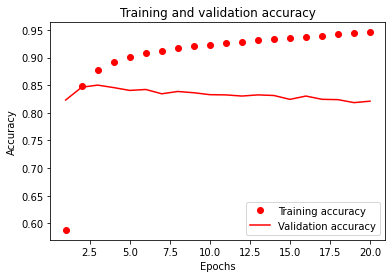

In [126]:
draw_loss_accuracy(history4)

9. 회고  

lms의 테스트코드를 기반으로 실습을 진행했는데, validation 85%정도의 정확도가 나왔는데 더이상 성능이 개선되지 않았다.  
test 세트는 최고 0.83으로 word2vec_ko 파라메타를 사용하여 임베딩하였을때도 0.01만 증가되어 차이를 느낄 수 없었다.  
가중치 파라메타는 임베딩 레이어에만 있는게 아니므로, 다른 레이어가 올바로 설정되지 않았을 것으로 생각된다.  


